* A linearly activated Autoencoder approximates PCA. Mathematically, minimizing the reconstruction error in PCA modeling is the same as a single layer linear Autoencoder.
* 
* An Autoencoder extends PCA to a nonlinear space. In other words, Autoencoders are a nonlinear extension of PCA.

Therefore, an Autoencoder should ideally have the properties of PCA. These properties are,

* Tied Weights: equal weights on Encoder and the corresponding Decoder layer.
* Orthogonal weights: each weight vector is independent of others.
* Uncorrelated features: output of the encoding layer are not correlated.
* Unit Norm: the weights on a layer have unit norm.

Therefore, it is important to incorporate these properties for a well-posed Autoencoder. By incorporating them, we will also

* Have Regularization. 
Orthogonality and Unit Norm constraint act as regularization. Additionally, the Tied Weights reduces the number of network parameters to almost half — another type of regularization.

* Address Exploding and Vanishing gradient. 
The Unit Norm constraint prevents weights from becoming large, and hence, resolves exploding gradient problem. Additionally, due to the Orthogonality constraint, only important/informative weights are non-zero. Therefore, sufficient information flows through these non-zero weights during back-propagation, and thus, avoiding vanishing gradients.

* Have Smaller network: Without the orthogonality, the encoder has redundant weights and features. 
To compensate the redundancy, the encoder size is increased. On the contrary, the orthogonality ensures each encoded feature has a piece of unique information — independent of the other features. This obviates the redundancy and we can have the same amount information encoded with a smaller encoder (layer).

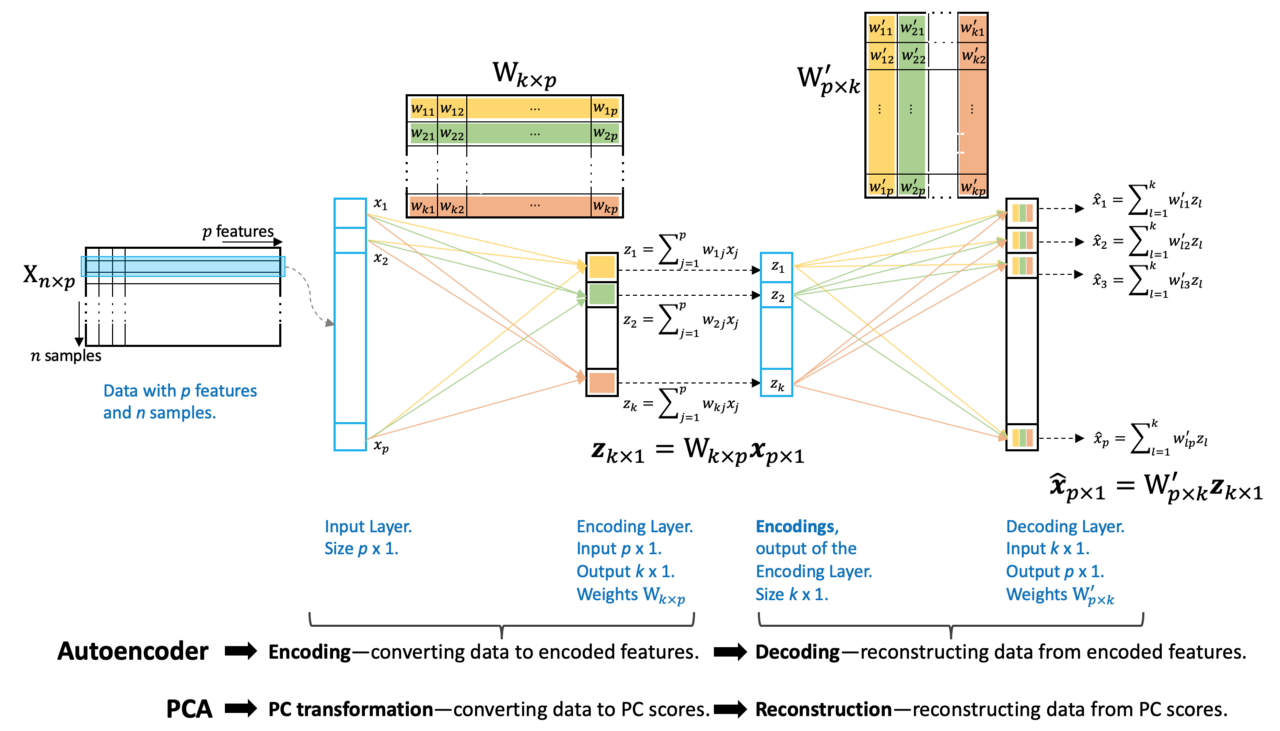

the Encoding process is similar to PC transformation. PC transformation is projecting the original data on the Principal Components to yield orthogonal features, called Principal Scores. Similarly, the Decoding process is similar to reconstructing the data from the Principal Scores. In both, Autoencoder and PCA, the model weights can be estimated by minimizing the reconstruction error.

# Input layer — data sample.

* In the Autoencoder, the data is inputted using an Input layer of size p.
* In PCA, the data is inputted as samples.

# Encoding — the projection of data on Principal Components.

* The size of the encoding layer is k. In PCA, k denotes the number of selected Principal Components (PCs).
* In both, we have k<p for dimension reduction. k ≥ p leads to an over-representative model, and consequently (close to) zero reconstruction error.
* A colored cell in the Encoding layer in Figure 1, is a computing node with p weights denoted as,

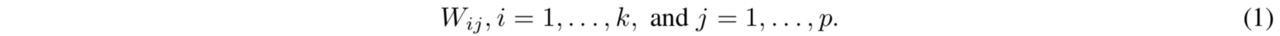

That is, for each Encoding node in 1,…,k we have a p-dimensional weight vector. This is equivalent to an eigenvector in PCA.

Encoding layer output in an Autoencoder is,

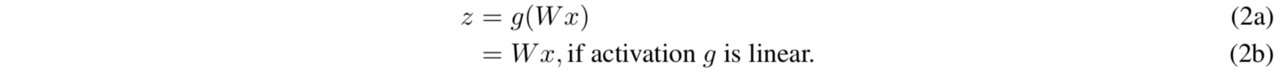

x is the input and W is the weight matrix. The function g is an activation function. g(Wx) is the output of the Encoding layer. If the activation is linear, this is equivalent to the Principal Scores in PCA.

# Decoding — reconstruction of data from the Principal Scores.

* The size of the decoding layer in Autoencoder and in PCA reconstruction must be the size of the input data, p.
* In a decoder, the data is reconstructed from the encodings as,

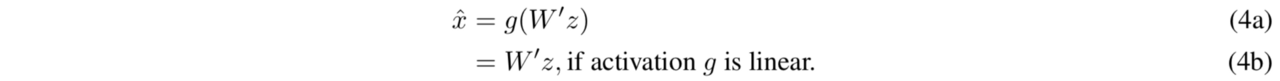

and similarly, in PCA, it is reconstructed as,

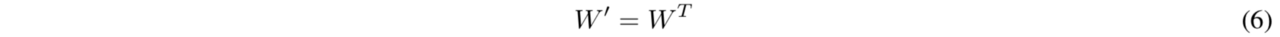

# Mathematically a Linear Autoencoder will be similar to PCA if,

* Tied Weights: In any general multilayer Autoencoder, the weight on layer l in the Encoder module is equal to the transpose of the weight on layer l from the end in the Decoder.

* Orthogonal weights: The weights on the Encoding layer is Orthogonal. The same orthogonality constraint can be enforced on intermediate Encoder layers for regularization.

* Uncorrelated features: The output of PCA, i.e. Principal Scores, are uncorrelated. 

* Unit Norm: An eigenvector in PCA is constrained to have a Unit Norm. Without this constraint, we will not get a proper solution as the variance of the projection can become arbitrarily large as long as the norm of the vector increases. For the same reason, the weights on the Encoding layer should be unit norm. This constraint should also be applied on other intermediate layers for regularization.

# Library

In [8]:
from numpy.random import seed
seed(123)

import tensorflow as tf
tf.random.set_seed(234)
import sklearn
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import decomposition
import scipy

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Layer, InputSpec
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers, activations, initializers, constraints, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.constraints import UnitNorm, Constraint

# Generate and prepare Data

In [9]:
n_dim = 5
cov = sklearn.datasets.make_spd_matrix(n_dim, random_state=None)
mu = np.random.normal(0, 0.1, n_dim)

n = 1000
X = np.random.multivariate_normal(mu, cov, n)
X_train, X_test = train_test_split(X, test_size=0.5, random_state=123)

# Scale the data between 0 and 1.
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[0.52681732, 0.62810095, 0.59284649, 0.52236607, 0.40995414],
       [0.41440755, 0.55001423, 0.63635182, 0.57413981, 0.30587165],
       [0.38378646, 0.14857921, 0.39851437, 0.34588993, 0.63374338],
       ...,
       [0.28371994, 0.4794476 , 0.48410551, 0.54245635, 0.59818998],
       [0.50510169, 0.76450508, 0.73271896, 0.69792451, 0.34080318],
       [0.3978237 , 0.50478323, 0.40141433, 0.67971132, 0.60012005]])

# Estimation Parameters

In [10]:
nb_epoch = 100
batch_size = 16
input_dim = X_train_scaled.shape[1] #num of predictor variables, 
encoding_dim = 2
learning_rate = 1e-3

# Autoencoder Optimization

## Custom Layer: Tied weights.

With this custom layer, we enforce the weights on encoder and decoder as equal. Mathematically, the transpose of decoder weights equals the encoder weights 

In [11]:
class DenseTied(Layer):
    def __init__(self, units,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 tied_to=None,
                 **kwargs):
        self.tied_to = tied_to
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super().__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True
                
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        if self.tied_to is not None:
            self.kernel = K.transpose(self.tied_to.kernel)
            self._non_trainable_weights.append(self.kernel)
        else:
            self.kernel = self.add_weight(shape=(input_dim, self.units),
                                          initializer=self.kernel_initializer,
                                          name='kernel',
                                          regularizer=self.kernel_regularizer,
                                          constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def call(self, inputs):
        output = K.dot(inputs, self.kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output

### Autoencoder with Tied Decoder.

In [12]:
encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias = True) 
decoder = DenseTied(input_dim, activation="linear", tied_to=encoder, use_bias = True)

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='sgd')
autoencoder.summary()

autoencoder.fit(X_train_scaled, X_train_scaled,
                epochs=nb_epoch,
                batch_size=batch_size,
                shuffle=True,
                verbose=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 12        
_________________________________________________________________
dense_tied (DenseTied)       (None, 5)                 27        
Total params: 27
Trainable params: 17
Non-trainable params: 10
_________________________________________________________________


### Equal weights.

In [13]:
w_encoder = np.round(np.transpose(autoencoder.layers[0].get_weights()[0]), 3)
w_decoder = np.round(autoencoder.layers[1].get_weights()[0], 3)
print('Encoder weights\n', w_encoder)
print('Decoder weights\n', w_decoder)

Encoder weights
 [[-0.398 -0.743  0.262 -0.096  0.238]
 [ 0.185  0.179 -0.132 -0.109 -0.368]]
Decoder weights
 [0.357 0.253 0.524 0.445 0.57 ]


In [14]:
train_predictions = autoencoder.predict(X_train_scaled)
print('Train reconstrunction error\n', sklearn.metrics.mean_squared_error(X_train_scaled, train_predictions))
test_predictions = autoencoder.predict(X_test_scaled)
print('Test reconstrunction error\n', sklearn.metrics.mean_squared_error(X_test_scaled, test_predictions))

Train reconstrunction error
 0.0191890568187478
Test reconstrunction error
 0.018203283098860615


In [15]:
b_encoder = np.round(np.transpose(autoencoder.layers[0].get_weights()[1]), 3)
b_decoder = np.round(np.transpose(autoencoder.layers[1].get_weights()[0]), 3)
print('Encoder bias\n', b_encoder)
print('Decoder bias\n', b_decoder)

Encoder bias
 [-0.046 -0.109]
Decoder bias
 [0.357 0.253 0.524 0.445 0.57 ]
